# CLIP-like models baselines on EuroSAT RGB

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import os
import random
from matplotlib import pyplot as plt
from PIL import Image

from tqdm import tqdm
import torch
import torch.nn.functional as F
import gc

from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
import seaborn as sn

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

In [ ]:
# Unzip EuroSAT folder
#!unzip "/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT.zip" -d "/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT data/"

In [ ]:
data_path = '/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT RGB data/2750/'

In [ ]:
os.listdir(data_path)

['SeaLake',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'Industrial',
 'HerbaceousVegetation',
 'Highway',
 'Forest',
 'River',
 'AnnualCrop']

In [ ]:
# Store the labels (slightly modified, these correspond to the ones in m-bigearthnet from GEO-Bench)
labels_map = {'SeaLake' : 'Sea or Lake',
              'Pasture': 'Pasture',
              'PermanentCrop': 'Permanent Crop',
              'Residential': 'Residential Buildings',
              'Industrial': 'Industrial Buildings',
              'HerbaceousVegetation': 'Herbaceous Vegetation',
              'Highway': 'Highway',
              'Forest': 'Forest',
              'River': 'River',
              'AnnualCrop': 'Annual Crop'}

# Define labels
labels = list(labels_map.values())

In [ ]:
total_images = 0
for folder in os.listdir(data_path):
    print(f'Folder {folder}:', len(os.listdir(data_path + folder)), 'images')
    total_images += len(os.listdir(data_path + folder))

print("Total:", total_images)

Folder SeaLake: 3000 images
Folder Pasture: 2000 images
Folder PermanentCrop: 2500 images
Folder Residential: 3000 images
Folder Industrial: 2500 images
Folder HerbaceousVegetation: 3000 images
Folder Highway: 2500 images
Folder Forest: 3000 images
Folder River: 2500 images
Folder AnnualCrop: 3000 images
Total: 27000


In [ ]:
# Build the TEST dataframe - 5000 images randomly sampled with seed = 42

test_images = []
for image_folder in os.listdir(data_path):
    random.seed(42)
    random_samples = random.sample(os.listdir(data_path + image_folder), 500)
    test_images += random_samples

print(len(test_images), "images")

data = []
for img_id in test_images:
    folder = img_id.split('_')[0]
    filename = os.path.join(data_path, folder, img_id)
    data.append({
        'image_id': img_id,
        'filename': filename,
        'label': labels_map[folder]
    })

test_df = pd.DataFrame(data)
print(test_df)

5000 images
                 image_id                                           filename  \
0        SeaLake_1041.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
1        SeaLake_2995.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
2        SeaLake_2715.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
3         SeaLake_516.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
4        SeaLake_1346.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
...                   ...                                                ...   
4995  AnnualCrop_2521.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
4996  AnnualCrop_2896.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
4997  AnnualCrop_1605.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
4998  AnnualCrop_1980.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
4999  AnnualCrop_1667.jpg  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   

            label  
0     S

In [ ]:
test_df.head()

,image_id,filename,label
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake


In [ ]:
test_df.tail()

,image_id,filename,label
4995,AnnualCrop_2521.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Annual Crop
4996,AnnualCrop_2896.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Annual Crop
4997,AnnualCrop_1605.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Annual Crop
4998,AnnualCrop_1980.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Annual Crop
4999,AnnualCrop_1667.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Annual Crop


In [ ]:
test_df.label.value_counts()

,count
label,
Sea or Lake,500
Pasture,500
Permanent Crop,500
Residential Buildings,500
Industrial Buildings,500
Herbaceous Vegetation,500
Highway,500
Forest,500
River,500


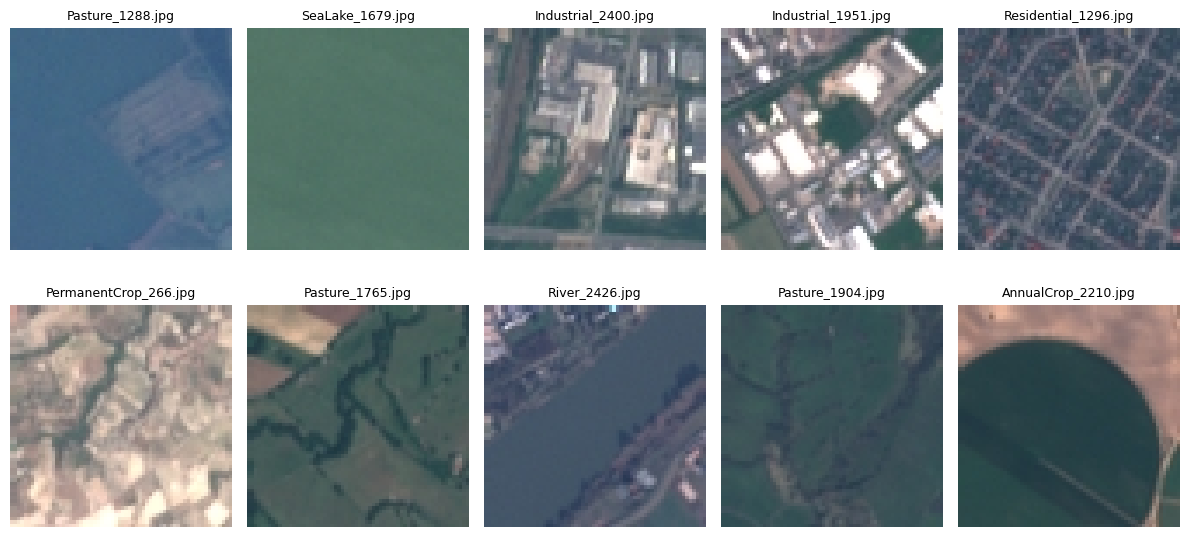

In [ ]:
# Plot a sample of images from the test dataframe
cols = 5
rows = 2

random.seed(42)
sample = random.sample(test_df.filename.tolist(), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, rows * 3))
axes = axes.flatten()

for i, image_path in enumerate(sample):
    im = Image.open(image_path)
    axes[i].imshow(im)
    axes[i].set_title(image_path.split('/')[-1], fontsize = 9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

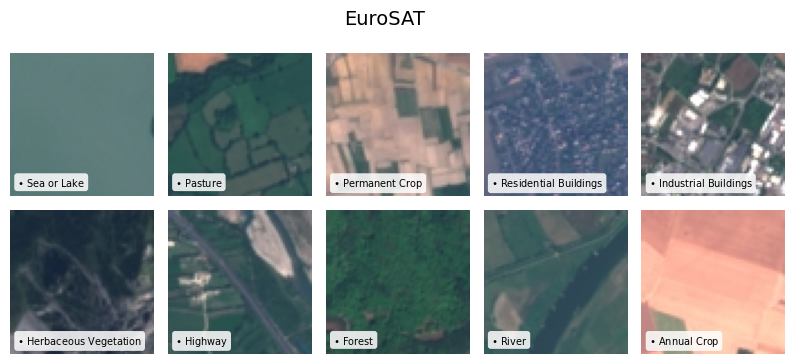

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Select images
images_to_plot = [] # file paths of images to plot
for image_folder in os.listdir(data_path):
    random.seed(73)
    images_to_plot += random.sample(os.listdir(data_path + image_folder), 1)

# Create filenames
for i, folder in enumerate(os.listdir(data_path)):
  images_to_plot[i] = os.path.join(data_path, folder, images_to_plot[i])

# ---- Sample setup ----
# images_to_plot contains the paths
# labels is already defined

# Grid layout (adjust as needed)
n_images = len(images_to_plot)
ncols = 5
nrows = 2 # (n_images + ncols - 1) // ncols

# ---- Plot ----
fig, axes = plt.subplots(nrows, ncols, figsize = (10, 4))
axes = axes.flatten()  # handle axes as 1D array for easy iteration

for idx, (ax, img_path, label) in enumerate(zip(axes, images_to_plot, labels)):
    im = Image.open(img_path)
    ax.imshow(im)
    ax.axis('off')

    # Draw label box (upper left corner)
    ax.text(
        0.05, 0.07,  # relative position inside axes
        r"$\bullet$ " + label,
        transform=ax.transAxes,
        fontsize=7,
        color='black',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round, pad=0.3', alpha=0.85), # background box
        # alpha is for transparency, 0 fully transparent and 1 fully opaque
    )

# Hide unused axes (if any)
for i in range(len(labels), len(axes)):
    axes[i].axis('off')

plt.suptitle("EuroSAT", fontsize=14)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
#plt.tight_layout() #rect=[0, 0, 1, 0.93]
plt.savefig("/content/drive/MyDrive/Thesis CLIP4EO/img/EuroSAT_image_grid.png")
plt.show()


In [ ]:
type(Image.open(test_df.iloc[0].filename))

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
test_df_normalized = test_df.copy()

## Utility functions

In [ ]:
def normalize(img):

    ''' Normalize images for display -> all values in [0, 1]. '''

    return (img - np.min(img)) / (np.max(img) - np.min(img))


def add_top_predictions_with_batches_jpg(input_df, model, preprocess, device, labels, output_path, tokenizer = 'default'):

    ''' Process images from input dataframe, using the specified model and labels.
        - 'tokenizer' needs to be specified when not using the standard CLIP '''

    # Set chunk and batch size
    chunk_size = 250
    batch_size = 8

    new_columns = [l.replace(' ', '_') + "_dotprod" for l in labels] + \
                  [l.replace(' ', '_') + "_softmax" for l in labels] + \
                  [l.replace(' ', '_') + "_sigmoid" for l in labels] + \
                  ["pred"]

    # Process images in chunks
    for chunk_start in tqdm(range(0, input_df.shape[0], chunk_size)):
        chunk_df = input_df.iloc[
            chunk_start : chunk_start + chunk_size
        ].copy()

        # Initialize new columns for each chunk
        for col in new_columns:
            chunk_df[col] = ""

        batch = []
        batch_indices = []  # stores row positions within chunk_df

        for index, filename in enumerate(chunk_df["filename"]):
            # index is relative to chunk_df
            try:

                image = preprocess(Image.open(filename)).unsqueeze(0).to(device)

                # WATCH OUT: hardcoded clip tokenixer here -> change it when the model changes!
                # TEMPLATE: 'a satellite photo of {class_name}' as in the papers
                if tokenizer == 'default': # go for standard CLIP tokenizer
                    text = clip.tokenize(['a satellite photo of ' + l.lower() for l in labels]).to(device)
                else: # go for model-specific tokenizer
                    text = tokenizer(['a satellite photo of ' + l.lower() for l in labels]).to(device)

                batch.append(image)
                batch_indices.append(index)  # store relative index

                # Process batch if full
                if len(batch) == batch_size:
                    with torch.no_grad():
                        batch_images = torch.cat(batch, dim=0)
                        image_features = model.encode_image(batch_images)
                        text_features = model.encode_text(text)

                    image_features /= image_features.norm(dim=-1, keepdim=True)
                    text_features /= text_features.norm(dim=-1, keepdim=True)

                    for i, img_feats in enumerate(image_features):
                        similarity = img_feats @ text_features.T # normalized dot product -> cosine similarity
                        softmax = (100.0 * img_feats @ text_features.T).softmax(dim=-1)
                        sigmoid = (img_feats @ text_features.T).sigmoid()
                        for j, label in enumerate(labels):
                            chunk_df.iloc[
                                batch_indices[i], chunk_df.columns.get_loc(new_columns[j])
                            ] = similarity[j].item()
                            chunk_df.iloc[
                                batch_indices[i], chunk_df.columns.get_loc(new_columns[len(labels) + j]) # 2 + j
                            ] = softmax[j].item()
                            chunk_df.iloc[
                                batch_indices[i], chunk_df.columns.get_loc(new_columns[2 * len(labels) + j]) # 4 + j
                            ] = sigmoid[j].item()
                        chunk_df.iloc[
                            batch_indices[i], chunk_df.columns.get_loc(new_columns[-1])
                        ] = labels[softmax.argmax()]  # softmax is chosen for final prediction

                    # Clear memory
                    del batch, batch_images, image_features
                    torch.cuda.empty_cache()
                    gc.collect()
                    batch = []
                    batch_indices = []

            except Exception as e:
                print(f"Error processing image {filename}: {e}")


        # Process remaining images in the batch (if any)
        if batch:
            with torch.no_grad():
                batch_images = torch.cat(batch, dim=0)
                image_features = model.encode_image(batch_images)
                text_features = model.encode_text(text)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            for i, img_feats in enumerate(image_features):
                similarity = img_feats @ text_features.T # normalized dot product -> cosine similarity
                softmax = (100.0 * img_feats @ text_features.T).softmax(dim=-1)
                sigmoid = (img_feats @ text_features.T).sigmoid()
                for j, label in enumerate(labels):
                    chunk_df.iloc[
                        batch_indices[i], chunk_df.columns.get_loc(new_columns[j])
                    ] = similarity[j].item()
                    chunk_df.iloc[
                        batch_indices[i], chunk_df.columns.get_loc(new_columns[len(labels) + j])
                    ] = softmax[j].item()
                    chunk_df.iloc[
                        batch_indices[i], chunk_df.columns.get_loc(new_columns[2 * len(labels) + j])
                    ] = sigmoid[j].item()
                chunk_df.iloc[
                    batch_indices[i], chunk_df.columns.get_loc(new_columns[-1])
                ] = labels[softmax.argmax()]  # softmax is chosen for final prediction

            del batch, batch_images, image_features
            torch.cuda.empty_cache()
            gc.collect()

        # Append results to CSV
        chunk_df.to_csv(
            f"{output_path}",
            mode = "a",
            index = False,
            header = (chunk_start == 0),
        )

        del chunk_df
        gc.collect()

    return


def add_top_predictions_with_chunks_jpg_siglip(input_df, model, processor, device, labels, output_path):

    ''' Process images from input dataframe using SigLIP model.
        Saves logit similarities and sigmoid probabilities per label, plus top prediction. '''

    chunk_size = 250

    new_columns = [l.replace(' ', '_') + "_logit" for l in labels] + \
                  [l.replace(' ', '_') + "_sigmoid_prob" for l in labels] + \
                  ["pred"]

    for chunk_start in tqdm(range(0, input_df.shape[0], chunk_size)):

        chunk_df = input_df.iloc[chunk_start : chunk_start + chunk_size].copy()

        # Initialize new columns
        for col in new_columns:
            chunk_df[col] = ""

        for index, filename in enumerate(chunk_df["filename"]):
            try:
                # Prepare text prompts
                texts = [f'a satellite photo of {label.lower()}' for label in labels]

                # Load and process image + text
                image = Image.open(filename)#.convert("RGB")
                inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")#.to(device)

                with torch.no_grad():
                    outputs = model(**inputs)

                logits = outputs.logits_per_image.squeeze(0)  # "flatten" the logits tensor into shape [10]
                probs = torch.sigmoid(logits)

                # Save logits and probabilities
                for j, label in enumerate(labels):
                    chunk_df.at[index + chunk_start, label.replace(' ', '_') + "_logit"] = logits[j].item()
                    chunk_df.at[index + chunk_start, label.replace(' ', '_') + "_sigmoid_prob"] = probs[j].item()

                # Save top prediction based on sigmoid probability
                pred_idx = probs.argmax().item()
                chunk_df.at[index + chunk_start, "pred"] = labels[pred_idx]

            except Exception as e:
                print(f"Error processing image {filename}: {e}")
                continue

        # Write results to CSV
        chunk_df.to_csv(
            f"{output_path}",
            mode = "a",
            index = False,
            header = (chunk_start == 0),
        )

        # Clear memory
        del chunk_df
        gc.collect()

    return


def add_top_predictions_with_batches_jpg_siglip2(input_df, model, preprocess, device, labels, output_path, tokenizer):

    ''' Process images from input dataframe, using the specified model and labels.
        - 'tokenizer' and 'preprocess' are meant to be the SigLIP2 ones '''

    # Set chunk and batch size
    chunk_size = 250
    batch_size = 8

    new_columns = [l.replace(' ', '_') + "_logit" for l in labels] + \
                  [l.replace(' ', '_') + "_sigmoid_prob" for l in labels] + \
                  ["pred"]

    # Process images in chunks
    for chunk_start in tqdm(range(0, input_df.shape[0], chunk_size)):
        chunk_df = input_df.iloc[
            chunk_start : chunk_start + chunk_size
        ].copy()

        # Initialize new columns for each chunk
        for col in new_columns:
            chunk_df[col] = ""

        batch = []
        batch_indices = []  # stores row positions within chunk_df

        for index, filename in enumerate(chunk_df["filename"]):
            # index is relative to chunk_df
            try:
                image = preprocess(Image.open(filename)).unsqueeze(0).to(device)
                text = tokenizer(['a satellite photo of ' + l.lower() for l in labels], context_length = model.context_length).to(device)

                batch.append(image)
                batch_indices.append(index)  # store relative index

                # Process batch if full
                if len(batch) == batch_size:
                    with torch.no_grad(): #, torch.amp.autocast('cuda'):
                        batch_images = torch.cat(batch, dim=0).to(device)
                        image_features = model.encode_image(batch_images, normalize = True)
                        text_features = model.encode_text(text, normalize = True)

                    for i, img_feats in enumerate(image_features):
                         # "flatten" the logits tensor into shape [10]
                        logits = (img_feats @ text_features.T * SigLIP2_model.logit_scale.exp() + SigLIP2_model.logit_bias).squeeze(0)
                        probs = torch.sigmoid(logits)
                        for j, label in enumerate(labels):
                            chunk_df.iloc[
                                batch_indices[i], chunk_df.columns.get_loc(new_columns[j])
                            ] = logits[j].item()
                            chunk_df.iloc[
                                batch_indices[i], chunk_df.columns.get_loc(new_columns[len(labels) + j]) # 2 + j
                            ] = probs[j].item()
                        chunk_df.iloc[
                            batch_indices[i], chunk_df.columns.get_loc(new_columns[-1])
                        ] = labels[probs.argmax()]  # sigmoid probs give final prediction

                    # Clear memory
                    del batch, batch_images, image_features
                    torch.cuda.empty_cache()
                    gc.collect()
                    batch = []
                    batch_indices = []

            except Exception as e:
                print(f"Error processing image {filename}: {e}")


        # Process remaining images in the batch (if any)
        if batch:
            with torch.no_grad(): #, torch.amp.autocast('cuda'):
                batch_images = torch.cat(batch, dim=0)
                image_features = model.encode_image(batch_images, normalize = True)
                text_features = model.encode_text(text, normalize = True)

            for i, img_feats in enumerate(image_features):
                # "flatten" the logits tensor into shape [10]
                logits = (img_feats @ text_features.T * SigLIP2_model.logit_scale.exp() + SigLIP2_model.logit_bias).squeeze(0)
                probs = torch.sigmoid(logits)
                for j, label in enumerate(labels):
                    chunk_df.iloc[
                        batch_indices[i], chunk_df.columns.get_loc(new_columns[j])
                    ] = logits[j].item()
                    chunk_df.iloc[
                        batch_indices[i], chunk_df.columns.get_loc(new_columns[len(labels) + j]) # 2 + j
                    ] = probs[j].item()
                chunk_df.iloc[
                    batch_indices[i], chunk_df.columns.get_loc(new_columns[-1])
                ] = labels[probs.argmax()]  # sigmoid probs give final prediction

            del batch, batch_images, image_features
            torch.cuda.empty_cache()
            gc.collect()

        # Append results to CSV
        chunk_df.to_csv(
            f"{output_path}",
            mode = "a",
            index = False,
            header = (chunk_start == 0),
        )

        del chunk_df
        gc.collect()

    return


def plot_confusion_matrix(y_true, y_pred, labels, model_name, output_file = None):

    ''' Given true and predicted labels, plot the confusion matrix
        for the current model. '''

    cm = confusion_matrix(y_true, y_pred, labels = labels)
    df_cfm = pd.DataFrame(cm, index = labels, columns = labels)
    plt.figure(figsize = (8, 7))
    #cell_value = df_cfm.map(lambda v: v if v else "")
    cfm_plot = sn.heatmap(df_cfm, annot = df_cfm, fmt = "",   # norm=LogNorm(),
                          linewidths = 0.5, cmap = "crest")   #linecolor="grey",
    plt.title(f"{model_name} - Confusion Matrix", fontsize = 14, pad = 12)
    plt.ylabel("True Label", fontsize = 12)
    plt.xlabel("Predicted Label", fontsize = 12)
    plt.tight_layout()
    if output_file:
      plt.savefig(f'/content/drive/MyDrive/Thesis CLIP4EO/img/{output_file}')
    plt.show()
    return

- Confusion Matrix plots: https://towardsdatascience.com/heatmap-for-confusion-matrix-in-python-20a9fc689665/

## Loading CLIP

In [ ]:
%%capture
#!conda install --yes -c pytorch pytorch=1.7.1 torchvision cpuonly #cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import random
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
CLIP_model, CLIP_preprocess = clip.load("ViT-B/32", device = device)
print("device =", device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 86.8MiB/s]


device = cuda


### CLIP ViT-B/32 Classification Predictions

- Single image


 SeaLake_2532.jpg 



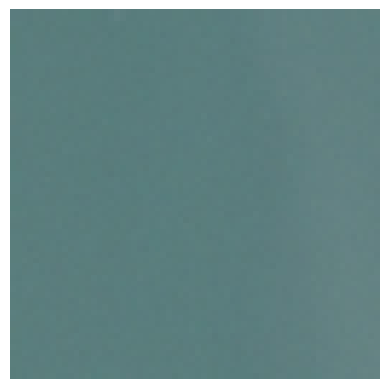


Top predictions:

     Sea or Lake: 41.02%
         Highway: 12.75%
           River: 12.58%
          Forest: 9.43%
Industrial Buildings: 6.07%
         Pasture: 5.67%
Residential Buildings: 3.59%
Herbaceous Vegetation: 3.47%
  Permanent Crop: 2.96%
     Annual Crop: 2.45%


In [ ]:
img_id = 'SeaLake_2532.jpg'
filename = test_df[test_df.image_id == img_id].filename.item()

print('\n', img_id, '\n')

im = Image.open(filename)
plt.imshow(im)
plt.axis("off")
plt.show()

# Preprocess
image_input = CLIP_preprocess(Image.open(filename)).unsqueeze(0).to(device)
text_input = clip.tokenize(labels).to(device)

# Calculate features
with torch.no_grad():
    image_features = CLIP_model.encode_image(image_input)
    text_features = CLIP_model.encode_text(text_input)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = image_features @ text_features.T # normalized dot product -> cosine similarity
softmax = (100.0 * image_features @ text_features.T).softmax(dim=-1)
sigmoid = (image_features @ text_features.T).sigmoid()

values, indices = softmax[0].topk(10)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

- Calculating predictions for whole input dataframe

In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    CLIP_model,
    CLIP_preprocess,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_CLIP_RGB.csv')

100%|██████████| 20/20 [31:36<00:00, 94.83s/it]


In [ ]:
output_df_clip = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_CLIP_RGB.csv')
output_df_clip.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.239261,0.230375,0.223908,0.213490,0.226674,0.219803,0.233443,...,0.557340,0.555744,0.553171,0.556427,0.554731,0.558097,0.558927,0.558980,0.557493,Sea or Lake
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.311946,0.294715,0.291733,0.296269,0.309150,0.282472,0.286674,...,0.573150,0.572420,0.573530,0.576678,0.570152,0.571182,0.571936,0.570831,0.571900,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.315999,0.288670,0.299329,0.292308,0.285298,0.279752,0.284577,...,0.571671,0.574279,0.572561,0.570845,0.569485,0.570668,0.572645,0.570615,0.575590,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.238726,0.229194,0.223514,0.212171,0.225447,0.218616,0.233510,...,0.557049,0.555647,0.552845,0.556124,0.554437,0.558114,0.558753,0.558953,0.557364,Sea or Lake
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.246914,0.234227,0.229610,0.222494,0.234656,0.224134,0.238329,...,0.558290,0.557152,0.555395,0.558396,0.555800,0.559302,0.560106,0.559938,0.559369,Sea or Lake


In [ ]:
output_df_clip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_clip.pred.value_counts()

,count
pred,
Industrial Buildings,977
Residential Buildings,812
Permanent Crop,679
Highway,596
Pasture,509
Annual Crop,491
Forest,421
Sea or Lake,383
River,130


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_clip["label"]
y_pred = output_df_clip["pred"]

accuracy_clip = accuracy_score(y_true, y_pred)
accuracy_clip

0.3876

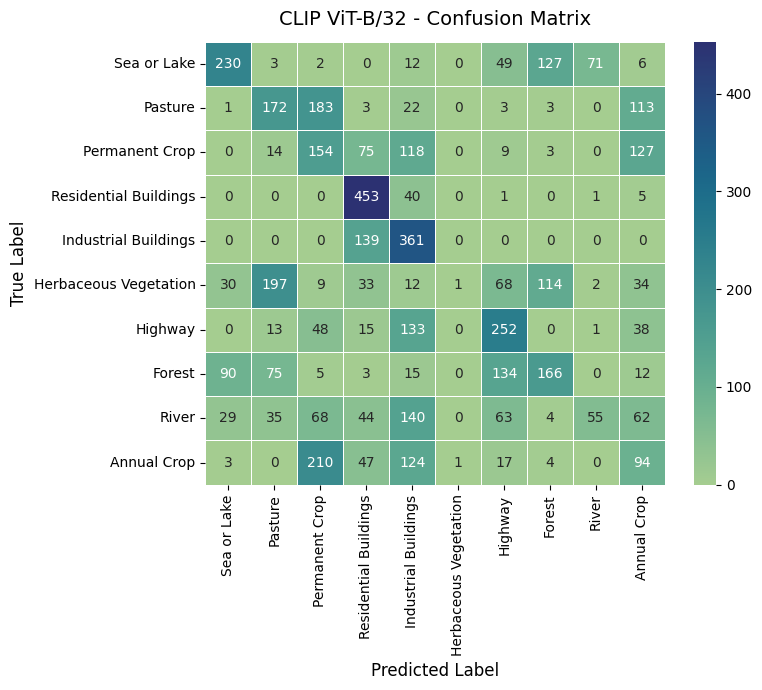

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'CLIP ViT-B/32', 'EuroSAT_CLIP_32_cm.png')

### CLIP Vit-B/16 Classification Predictions

In [ ]:
import random
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
CLIP_model_16, CLIP_preprocess_16 = clip.load("ViT-B/16", device = device)
print("device =", device)

device = cuda



 SeaLake_2532.jpg 



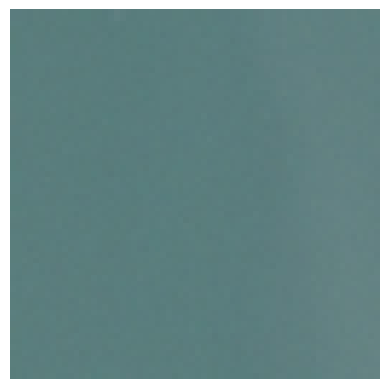


Top predictions:

     Sea or Lake: 43.21%
         Pasture: 12.19%
  Permanent Crop: 10.93%
         Highway: 8.92%
     Annual Crop: 8.51%
           River: 7.51%
          Forest: 3.60%
Residential Buildings: 1.90%
Industrial Buildings: 1.62%
Herbaceous Vegetation: 1.62%


In [ ]:
img_id = 'SeaLake_2532.jpg'
filename = test_df[test_df.image_id == img_id].filename.item()

print('\n', img_id, '\n')

im = Image.open(filename)
plt.imshow(im)
plt.axis("off")
plt.show()

# Preprocess
image_input = CLIP_preprocess_16(Image.open(filename)).unsqueeze(0).to(device)
text_input = clip.tokenize(labels).to(device)

# Calculate features
with torch.no_grad():
    image_features = CLIP_model_16.encode_image(image_input)
    text_features = CLIP_model_16.encode_text(text_input)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = image_features @ text_features.T # normalized dot product -> cosine similarity
softmax = (100.0 * image_features @ text_features.T).softmax(dim=-1)
sigmoid = (image_features @ text_features.T).sigmoid()

values, indices = softmax[0].topk(10)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    CLIP_model_16,
    CLIP_preprocess_16,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_CLIP_ViTB16_RGB.csv')

100%|██████████| 20/20 [40:53<00:00, 122.70s/it]


In [ ]:
output_df_clip_16 = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_CLIP_ViTB16_RGB.csv')
output_df_clip_16.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.246216,0.246216,0.256348,0.238770,0.231201,0.234863,0.254395,...,0.561035,0.563965,0.559570,0.557617,0.558594,0.563477,0.560059,0.560059,0.563477,Permanent Crop
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.291260,0.273682,0.272705,0.260498,0.258789,0.261475,0.263672,...,0.567871,0.567871,0.564941,0.564453,0.564941,0.565430,0.565430,0.569336,0.568848,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.320068,0.304199,0.314453,0.295410,0.289795,0.286621,0.312500,...,0.575684,0.578125,0.573242,0.571777,0.571289,0.577637,0.574707,0.575195,0.578125,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.247681,0.246948,0.255859,0.238525,0.229492,0.235718,0.256104,...,0.561523,0.563477,0.559570,0.557129,0.558594,0.563477,0.560547,0.560547,0.563477,Highway
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.244751,0.248169,0.255615,0.236328,0.228638,0.235840,0.255127,...,0.561523,0.563477,0.558594,0.557129,0.558594,0.563477,0.560059,0.559570,0.563477,Permanent Crop


In [ ]:
output_df_clip_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_clip_16.pred.value_counts()

,count
pred,
Annual Crop,1332
Permanent Crop,844
Residential Buildings,603
Industrial Buildings,571
Highway,510
Pasture,337
Forest,332
River,266
Sea or Lake,188


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_clip_16["label"]
y_pred = output_df_clip_16["pred"]

accuracy_clip_16 = accuracy_score(y_true, y_pred)
accuracy_clip_16

0.4398

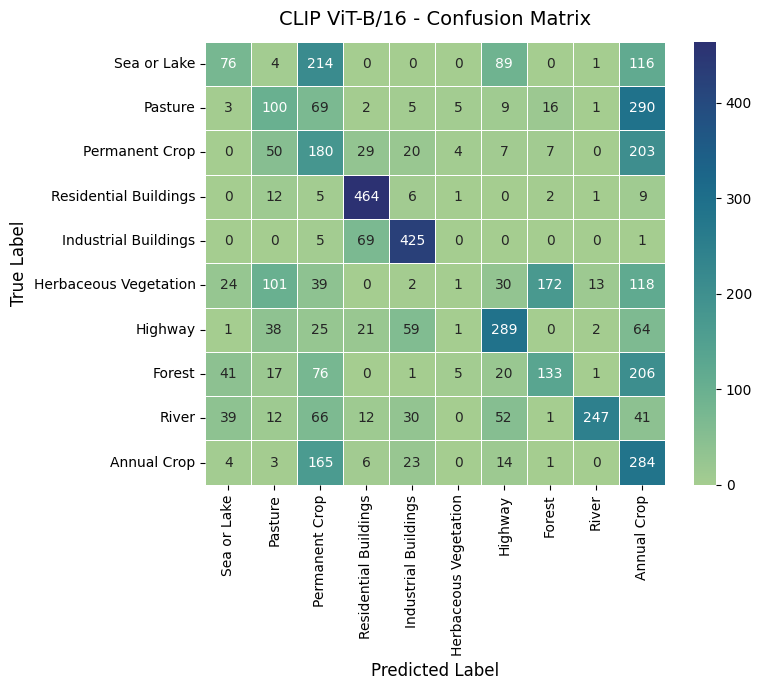

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'CLIP ViT-B/16')

## Loading RemoteCLIP

In [ ]:
%%capture
! pip install open-clip-torch

In [ ]:
import random
import torch, open_clip
from PIL import Image
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

# Selecting device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# Download model checkpoint
model_name = 'ViT-B-32' # or 'RN50' or 'ViT-L-14'
checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir = 'checkpoints')
print(f'RemoteCLIP-{model_name} is downloaded to {checkpoint_path}.')

# Loading the RemoteCLIP model
RemoteCLIP_model, _, RemoteCLIP_preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

ckpt = torch.load(f"checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt", map_location = "cpu")
message = RemoteCLIP_model.load_state_dict(ckpt)
print(message)

RemoteCLIP_model = RemoteCLIP_model.to(device).eval()

device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


RemoteCLIP-ViT-B-32.pt:   0%|          | 0.00/605M [00:00<?, ?B/s]

RemoteCLIP-ViT-B-32 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt.
<All keys matched successfully>


**Note on `model.eval()`**

From the docs, this function sets a torch.nn.Module in evaluation mode. <br>
Equivalent to self.train = False <br>
It can be thought of as a kind of switch for some specific layers/parts of the model that are designed to behave differently during training and inference (evaluation) time, like Dropouts Layers, BatchNorm Layers etc. They need to be turned off during model evaluation, and this is what `eval()` does. Common practice for evaluating/validation is using `torch.no_grad()` in pair with this function, to turn off gradients computation.

```
# evaluate model:
model.eval()

with torch.no_grad():
    ...
    out_data = model(data)
    ...
```
However, if the model goes back to training after evaluation phase, we need to set explicitly:
```
# training step
...
model.train()
...
```

Sources:
- https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
- https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch



### RemoteCLIP Classification Predictions

In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    RemoteCLIP_model,
    RemoteCLIP_preprocess,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_RemoteCLIP_RGB.csv',
    tokenizer)

100%|██████████| 20/20 [53:37<00:00, 160.87s/it]


In [ ]:
output_df_remoteclip = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_RemoteCLIP_RGB.csv')
output_df_remoteclip.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.223821,0.160923,0.195863,0.159411,0.155234,0.215015,0.192892,...,0.540144,0.548810,0.539768,0.538731,0.553548,0.548074,0.549153,0.549758,0.551720,Sea or Lake
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.248220,0.219474,0.228046,0.175444,0.163150,0.265403,0.198175,...,0.554649,0.556766,0.543749,0.540697,0.565964,0.549382,0.555179,0.565348,0.558664,Herbaceous Vegetation
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.233547,0.180096,0.203832,0.170513,0.160997,0.230334,0.201112,...,0.544903,0.550782,0.542525,0.540163,0.557330,0.550109,0.551349,0.552757,0.553699,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.227203,0.161486,0.196268,0.164860,0.158928,0.217370,0.197121,...,0.540284,0.548910,0.541122,0.539649,0.554129,0.549121,0.549653,0.550478,0.552010,Sea or Lake
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.231581,0.169774,0.204468,0.175710,0.169672,0.223788,0.201661,...,0.542342,0.550940,0.543815,0.542317,0.555715,0.550245,0.551495,0.551710,0.553443,Sea or Lake


In [ ]:
output_df_remoteclip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_remoteclip.pred.value_counts()

,count
pred,
Herbaceous Vegetation,1701
Annual Crop,845
River,685
Highway,486
Residential Buildings,421
Sea or Lake,398
Permanent Crop,219
Forest,217
Industrial Buildings,22


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_remoteclip["label"]
y_pred = output_df_remoteclip["pred"]

accuracy_remoteclip = accuracy_score(y_true, y_pred)
accuracy_remoteclip

0.3734

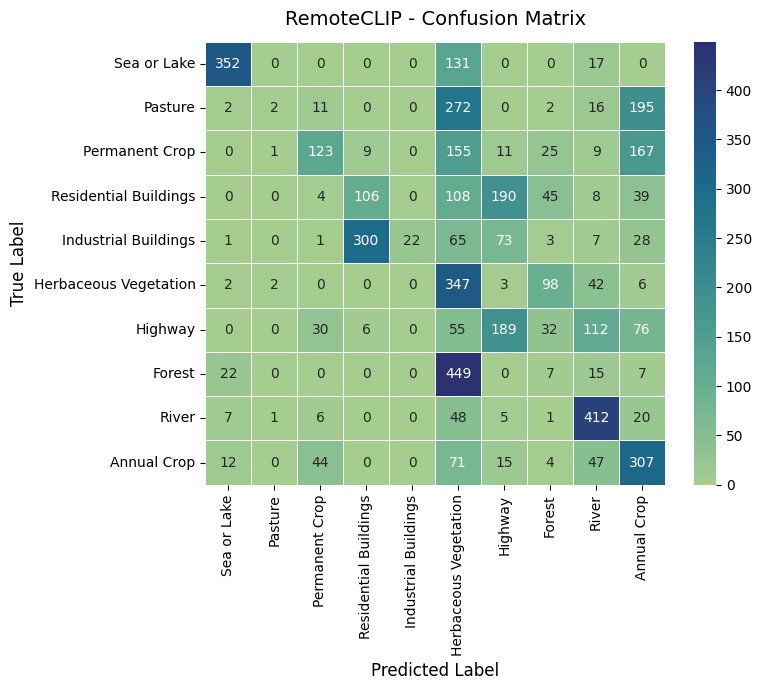

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'RemoteCLIP', 'EuroSAT_RemoteCLIP_32_cm.png')

## Loading GeoRSCLIP

A state-of-the-art model for zero shot classification and cross-modal retrieval in Remote Sensing, improving on previous results (presented in 2023, revised in 2024).

In [ ]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install pillow pandas scikit-learn ftfy tqdm matplotlib transformers adapter-transformers open_clip_torch pycocotools timm clip-benchmark torch-rs

Looking in indexes: https://download.pytorch.org/whl/cu118
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 5.9 MB/s eta 0:00:00
  Created wheel for adapter-transformers: filename=adapter_transformers-4.0.0-py3-none-any.whl size=2630 sha256=2f0db6c6e47e760f521f13350c431203e908c3fd3c97fe134ac27b8c3c3b32bf
  Stored in di

In [ ]:
# Takes around 10 mins
! git clone https://huggingface.co/Zilun/GeoRSCLIP
! cd GeoRSCLIP

Cloning into 'GeoRSCLIP'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 75 (delta 2), reused 0 (delta 0), pack-reused 67 (from 1)
Unpacking objects: 100% (75/75), 21.36 KiB | 465.00 KiB/s, done.

Exiting because of "interrupt" signal.
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'

^C


In [ ]:
# Add inference folder to environment variable
import sys
sys.path.append("/content/GeoRSCLIP/codebase/inference")

In [ ]:
import os
import torch
import open_clip
import inference_tool
from inference_tool import get_preprocess
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# Selecting device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# Loading the GeoRSCLIP model from checkpoint
ckpt_path = "/content/GeoRSCLIP/ckpt/RS5M_ViT-B-32.pt"
GeoRSCLIP_model, _, _ = open_clip.create_model_and_transforms("ViT-B/32", pretrained = "openai")
tokenizer = open_clip.get_tokenizer('ViT-B-32')

checkpoint = torch.load(ckpt_path, map_location = "cpu")
message = GeoRSCLIP_model.load_state_dict(checkpoint, strict = False)
print(message)

GeoRSCLIP_model = GeoRSCLIP_model.to(device).eval()
GeoRSCLIP_preprocess = get_preprocess(
      image_resolution = 224,
)

device: cpu


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


<All keys matched successfully>


**Note on `to(device)` function**

Semantically, the nn.Module.to(device) function moves the model to the device. However, the effect of using it with *models* and with *tensors* is different. See the example below: <br>
For TENSORS:
```
# tensor a is in CPU
device = torch.device('cuda:0')
b = a.to(device)
# a is still in CPU!
# b is in GPU!
# a and b are different
```
For MODELS:
```
# model a is in CPU
device = torch.device('cuda:0')
b = a.to(device)
# a and b are in GPU
# a and b point to the same model
```

Sources:
- https://stackoverflow.com/questions/59560043/what-is-the-difference-between-model-todevice-and-model-model-todevice

### GeorSCLIP Classification Predictions

In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    GeoRSCLIP_model,
    GeoRSCLIP_preprocess,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_GeoRSCLIP_RGB.csv',
    tokenizer)

100%|██████████| 20/20 [30:56<00:00, 92.83s/it]


In [ ]:
output_df_georsclip = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_GeoRSCLIP_RGB.csv')
output_df_georsclip.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.219472,0.201266,0.202794,0.198170,0.196831,0.208250,0.214285,...,0.550147,0.550525,0.549381,0.549049,0.551875,0.553367,0.548280,0.548351,0.554019,Sea or Lake
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.262573,0.194538,0.210560,0.178734,0.177764,0.224734,0.209360,...,0.548482,0.552446,0.544565,0.544324,0.555948,0.552150,0.551188,0.556710,0.553920,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.274111,0.221540,0.234641,0.222833,0.207922,0.234259,0.228151,...,0.555160,0.558393,0.555479,0.551794,0.558298,0.556792,0.555602,0.557120,0.560279,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.220467,0.201992,0.203048,0.198136,0.196332,0.208218,0.213901,...,0.550327,0.550588,0.549373,0.548926,0.551867,0.553272,0.548530,0.548234,0.554131,Sea or Lake
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.219027,0.200275,0.202044,0.199771,0.198910,0.209650,0.215748,...,0.549902,0.550340,0.549777,0.549564,0.552221,0.553729,0.548141,0.548223,0.554327,Sea or Lake


In [ ]:
output_df_georsclip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_georsclip.pred.value_counts()

,count
pred,
Sea or Lake,976
Residential Buildings,880
Highway,574
Herbaceous Vegetation,524
Permanent Crop,502
Annual Crop,437
River,409
Forest,356
Industrial Buildings,180


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_georsclip["label"]
y_pred = output_df_georsclip["pred"]

accuracy_georsclip = accuracy_score(y_true, y_pred)
accuracy_georsclip

0.5354

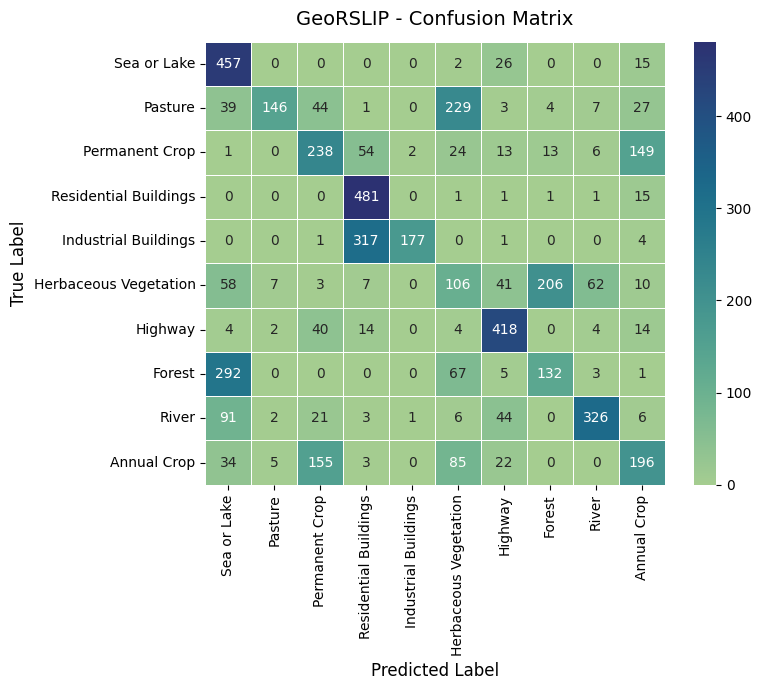

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'GeoRSLIP', 'EuroSAT_GeoRSCLIP_32_cm.png')

## Loading RS-M-CLIP

In [ ]:
%%capture
! pip install open-clip-torch

In [ ]:
import torch
import open_clip

# Selecting device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

RSMCLIP_model, RSMCLIP_preprocess, RSMCLIP_preprocess_val = open_clip.create_model_and_transforms('hf-hub:joaodaniel/RS-M-CLIP')
RSMCLIP_tokenizer = open_clip.get_tokenizer('hf-hub:joaodaniel/RS-M-CLIP')
RSMCLIP_model = RSMCLIP_model.to(device).eval()

device: cpu


open_clip_model.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

### RS-M-CLIP Classification Predictions

In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    RSMCLIP_model,
    RSMCLIP_preprocess,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_RS-M-CLIP_RGB.csv',
    RSMCLIP_tokenizer)

100%|██████████| 20/20 [43:57<00:00, 131.89s/it]


In [ ]:
output_df_rsmclip = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_RS-M-CLIP_RGB.csv')
output_df_rsmclip.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.153643,0.127272,0.146112,0.020374,0.128152,0.115204,0.037703,...,0.531775,0.536463,0.505093,0.531994,0.528769,0.509425,0.531064,0.523056,0.535976,Sea or Lake
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.044338,-0.042471,-0.003563,-0.069155,-0.036535,0.002561,-0.009988,...,0.489384,0.499109,0.482718,0.490867,0.500640,0.497503,0.484163,0.494373,0.486334,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.074425,0.048555,0.045558,-0.038509,0.027017,0.046766,-0.023014,...,0.512136,0.511387,0.490374,0.506754,0.511689,0.494247,0.515807,0.509049,0.492004,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.170503,0.131362,0.150479,0.040128,0.161588,0.119509,0.054076,...,0.532793,0.537549,0.510031,0.540309,0.529842,0.513516,0.537701,0.528017,0.538067,Sea or Lake
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.130396,0.098441,0.116211,-0.009142,0.117506,0.085352,0.015454,...,0.524590,0.529020,0.497715,0.529343,0.521325,0.503864,0.526958,0.518832,0.527122,Sea or Lake


In [ ]:
output_df_rsmclip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_rsmclip.pred.value_counts()

,count
pred,
River,1408
Sea or Lake,1395
Permanent Crop,417
Annual Crop,402
Highway,370
Forest,362
Herbaceous Vegetation,205
Industrial Buildings,160
Pasture,157


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_rsmclip["label"]
y_pred = output_df_rsmclip["pred"]

accuracy_rsmclip = accuracy_score(y_true, y_pred)
accuracy_rsmclip

0.2586

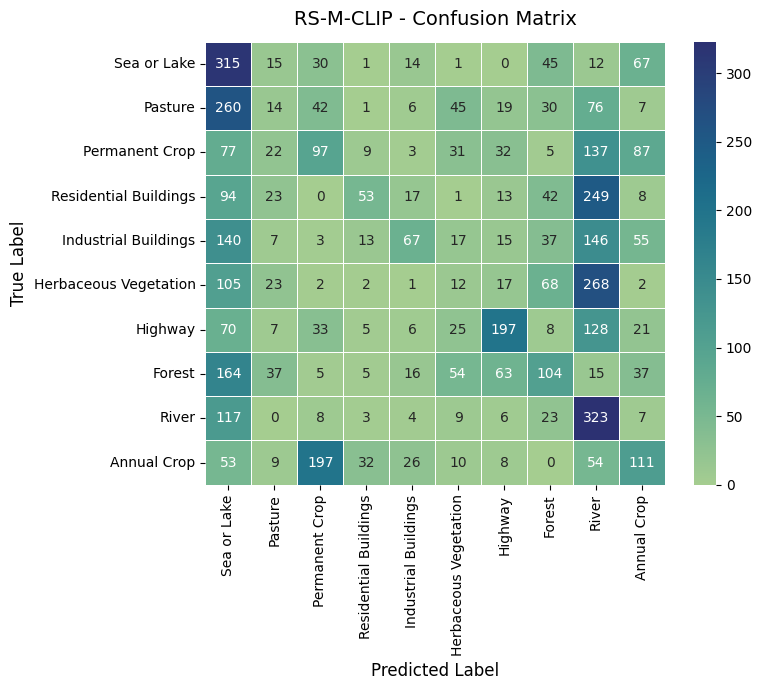

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'RS-M-CLIP')

## Loading SkyCLIP

- Downloading the model checkpoints:

In [ ]:
!curl -O https://opendatasharing.s3.us-west-2.amazonaws.com/SkyScript/ckpt/SkyCLIP_ViT_B32_top50pct.zip #{MODEL_NAME}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1445M  100 1445M    0     0  17.6M      0  0:01:21  0:01:21 --:--:-- 27.6M


In [ ]:
!unzip /content/SkyCLIP_ViT_B32_top50pct.zip

Archive:  /content/SkyCLIP_ViT_B32_top50pct.zip
   creating: SkyCLIP_ViT_B32_top50pct/
  inflating: SkyCLIP_ViT_B32_top50pct/epoch_20.pt  


In [ ]:
!git clone https://github.com/wangzhecheng/SkyScript.git

Cloning into 'SkyScript'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 192 (delta 102), reused 165 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (192/192), 1.46 MiB | 3.82 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [ ]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
# List all installed packages and their version
#!pip list

# Check for single package version
import tqdm
print(tqdm.__version__)

4.67.1


In [ ]:
import sys
sys.path.append('/content/SkyScript')

In [ ]:
import torch
from src.open_clip.factory import create_model_and_transforms, get_tokenizer
from torch.utils.data import Dataset, DataLoader
from src.training.precision import get_autocast

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
model_arch_name = 'ViT-B-32' # or 'ViT-L-14'
ckpt_name = '/content/SkyCLIP_ViT_B32_top50pct/epoch_20.pt' # '/THE/PATH/TO/MODEL/CHECKPOINT' # replace this with the path to the .pt file (get from above)

device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

device: cuda


> **NOTE**: to make it work, go into SkyScript > src > open_clip > factory.py and do the following:
  1. Add `import numpy` among imports
  2. Add `torch.serialization.add_safe_globals([numpy.core.multiarray.scalar])` after imports, just before functions definition
  3. In the function `load_state_dict` at line 93, in the `torch.load` function, set `weights_only = False`

In [ ]:
import numpy as np
import random

def random_seed(seed=42, rank=0):
    torch.manual_seed(seed + rank)
    np.random.seed(seed + rank)
    random.seed(seed + rank)

#force_quick_gelu = True

random_seed(42, 0)
precision = 'amp'
autocast = get_autocast(precision)

#if 'ViT-B-32' in model_arch_name:

SkyCLIP_model, _, SkyCLIP_preprocess_val = create_model_and_transforms(
        model_arch_name,
        ckpt_name,
        precision=precision,
        device=device,
        output_dict=True,
    )

# else:
#     model, _, preprocess_val = create_model_and_transforms(
#             model_arch_name,
#             ckpt_name,
#             precision=precision,
#             device=device,
#             output_dict=True,
#             force_quick_gelu=force_quick_gelu,
#         )

tokenizer = get_tokenizer(model_arch_name)

In [ ]:
SkyCLIP_model = SkyCLIP_model.eval()

### SkyCLIP Classification Predictions


 SeaLake_2532.jpg 



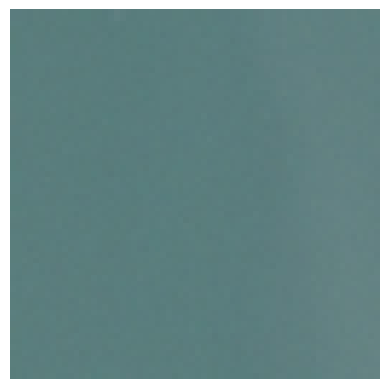


Top predictions:

           River: 45.50%
     Sea or Lake: 34.48%
  Permanent Crop: 12.32%
         Highway: 4.35%
          Forest: 1.35%
     Annual Crop: 0.89%
         Pasture: 0.46%
Herbaceous Vegetation: 0.26%
Industrial Buildings: 0.24%
Residential Buildings: 0.14%
['Sea or Lake', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'Industrial Buildings', 'Herbaceous Vegetation', 'Highway', 'Forest', 'River', 'Annual Crop']
tensor([[0.2518, 0.2086, 0.2415, 0.1969, 0.2021, 0.2029, 0.2311, 0.2194, 0.2546,
         0.2153]], device='cuda:0')
tensor([[0.3448, 0.0046, 0.1232, 0.0014, 0.0024, 0.0026, 0.0435, 0.0135, 0.4550,
         0.0089]], device='cuda:0')
tensor([[0.5626, 0.5520, 0.5601, 0.5491, 0.5504, 0.5506, 0.5575, 0.5546, 0.5633,
         0.5536]], device='cuda:0')


In [ ]:
img_id = 'SeaLake_2532.jpg'
filename = test_df[test_df.image_id == img_id].filename.item()

print('\n', img_id, '\n')

im = Image.open(filename)
plt.imshow(im)
plt.axis("off")
plt.show()

# Preprocess
image_input = SkyCLIP_preprocess_val(Image.open(filename)).unsqueeze(0).to(device)
text_input = tokenizer(labels).to(device)

# Calculate features
with torch.no_grad():
    image_features = SkyCLIP_model.encode_image(image_input, normalize=True)
    text_features = SkyCLIP_model.encode_text(text_input, normalize=True)

# Pick the top 5 most similar labels for the image
# image_features /= image_features.norm(dim=-1, keepdim=True)
# text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = image_features @ text_features.T # normalized dot product -> cosine similarity
softmax = (100.0 * image_features @ text_features.T).softmax(dim=-1)
sigmoid = (image_features @ text_features.T).sigmoid()

values, indices = softmax[0].topk(10)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

print(labels)
print(similarity)
print(softmax)
print(sigmoid)

In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    SkyCLIP_model,
    SkyCLIP_preprocess_val,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_SkyCLIP_RGB.csv',
    tokenizer)

100%|██████████| 20/20 [38:13<00:00, 114.68s/it]


In [ ]:
output_df_skyclip = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_SkyCLIP_RGB.csv')
output_df_skyclip.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.254481,0.228785,0.244820,0.213090,0.222322,0.222451,0.245681,...,0.556948,0.560901,0.553072,0.555353,0.555385,0.561113,0.559898,0.562229,0.561320,Sea or Lake
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.350582,0.298139,0.316571,0.260910,0.261153,0.308650,0.278880,...,0.573988,0.578488,0.564860,0.564920,0.576556,0.569272,0.574281,0.579184,0.575623,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.340652,0.290823,0.310865,0.259738,0.263479,0.299749,0.275457,...,0.572198,0.577096,0.564572,0.565491,0.574381,0.568432,0.575140,0.577330,0.573593,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.253795,0.230500,0.246277,0.213697,0.223324,0.224220,0.246131,...,0.557371,0.561260,0.553222,0.555600,0.555821,0.561224,0.560071,0.561742,0.561482,Sea or Lake
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.258541,0.236738,0.251255,0.218983,0.227628,0.231803,0.250187,...,0.558910,0.562485,0.554528,0.556662,0.557693,0.562223,0.561172,0.562680,0.562508,Sea or Lake


In [ ]:
output_df_skyclip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_skyclip.pred.value_counts()

,count
pred,
Permanent Crop,1456
Sea or Lake,1087
Forest,646
Industrial Buildings,435
Residential Buildings,422
Highway,375
River,342
Pasture,162
Herbaceous Vegetation,43


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_skyclip["label"]
y_pred = output_df_skyclip["pred"]

accuracy_skyclip = accuracy_score(y_true, y_pred)
accuracy_skyclip

0.5226

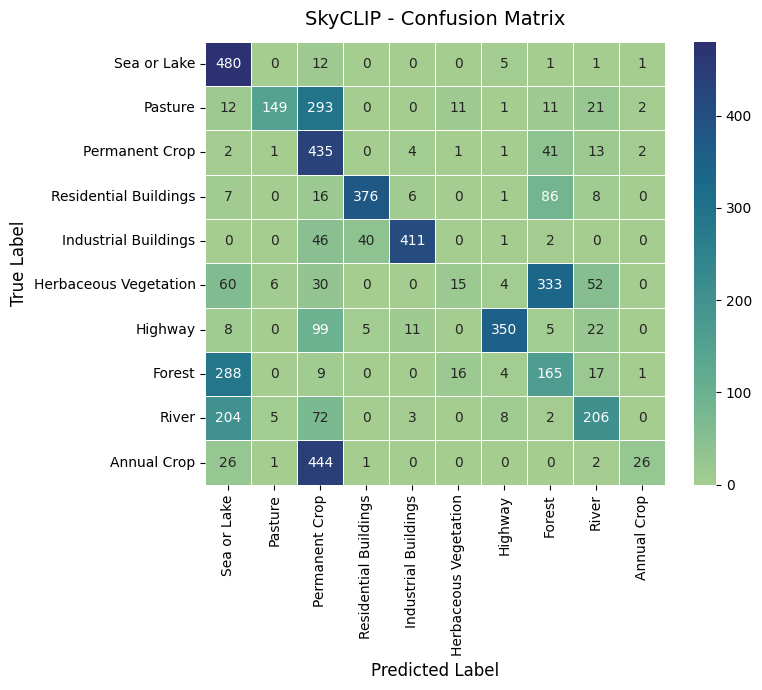

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'SkyCLIP', 'EuroSAT_SkyCLIP_32_cm.png')

## Loading OpenCLIP

An open source implementation of OpenAI's CLIP (Contrastive Language-Image Pre-training).

Github repo available at https://github.com/mlfoundations/open_clip

In [ ]:
! pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [ ]:
import open_clip

open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [ ]:
OpenCLIP_model, _, OpenCLIP_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained = 'laion2b_s34b_b79k')
OpenCLIP_model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device =", device)

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

### OpenCLIP ViT-B/32 Classification Predictions


 SeaLake_2532.jpg 



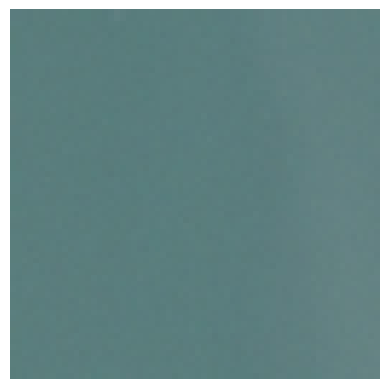


Top predictions:

           River: 92.13%
         Highway: 3.80%
  Permanent Crop: 2.30%
          Forest: 0.74%
     Sea or Lake: 0.46%
     Annual Crop: 0.42%
         Pasture: 0.10%
Herbaceous Vegetation: 0.04%
Industrial Buildings: 0.01%
Residential Buildings: 0.00%


In [ ]:
img_id = 'SeaLake_2532.jpg'
filename = test_df[test_df.image_id == img_id].filename.item()

print('\n', img_id, '\n')

im = Image.open(filename)
plt.imshow(im)
plt.axis("off")
plt.show()

# Preprocess
image_input = OpenCLIP_preprocess(Image.open(filename)).unsqueeze(0).to(device)
text_input = tokenizer(labels).to(device)

# Calculate features
with torch.no_grad(): #, torch.autocast("cuda")
    image_features = OpenCLIP_model.encode_image(image_input)
    text_features = OpenCLIP_model.encode_text(text_input)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = image_features @ text_features.T # normalized dot product -> cosine similarity
softmax = (100.0 * image_features @ text_features.T).softmax(dim=-1)
sigmoid = (image_features @ text_features.T).sigmoid()

values, indices = softmax[0].topk(10)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    OpenCLIP_model,
    OpenCLIP_preprocess,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_OpenCLIP_RGB.csv',
    tokenizer)

100%|██████████| 20/20 [1:00:44<00:00, 182.25s/it]


In [ ]:
output_df_openclip = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_OpenCLIP_RGB.csv')
output_df_openclip.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.186634,0.181519,0.205932,0.155993,0.173903,0.154652,0.186923,...,0.545256,0.551302,0.538919,0.543367,0.538586,0.546595,0.541980,0.546485,0.549938,Permanent Crop
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.310919,0.258601,0.266527,0.214920,0.230334,0.258315,0.256090,...,0.564292,0.566240,0.553524,0.557330,0.564222,0.563675,0.563259,0.571284,0.562398,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.293253,0.255677,0.271420,0.220640,0.224984,0.262793,0.255352,...,0.563573,0.567442,0.554937,0.556010,0.565323,0.563493,0.564751,0.566565,0.566590,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.177982,0.174465,0.198769,0.150355,0.169631,0.147027,0.178263,...,0.543506,0.549529,0.537518,0.542306,0.536691,0.544448,0.540212,0.544068,0.548135,Permanent Crop
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.188832,0.186494,0.210292,0.161617,0.179008,0.159740,0.188382,...,0.546489,0.552380,0.540317,0.544633,0.539850,0.546957,0.542639,0.546638,0.551047,Permanent Crop


In [ ]:
output_df_openclip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_openclip.pred.value_counts()

,count
pred,
Permanent Crop,1541
Sea or Lake,681
Residential Buildings,567
Industrial Buildings,541
Pasture,516
Highway,348
Forest,291
Annual Crop,278
River,229


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_openclip["label"]
y_pred = output_df_openclip["pred"]

accuracy_openclip = accuracy_score(y_true, y_pred)
accuracy_openclip

0.4476

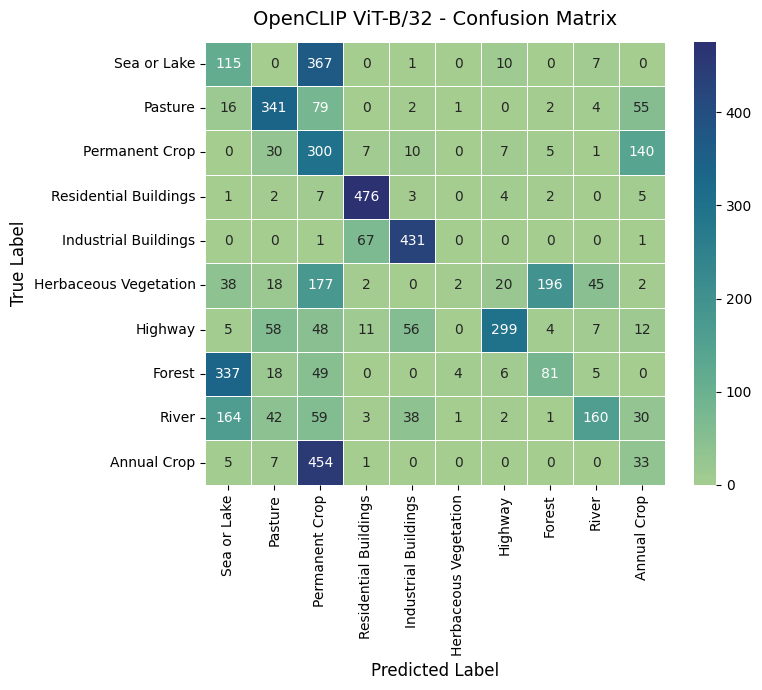

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'OpenCLIP ViT-B/32')

### OpenCLIP ViT-B/16 Classification Predictions

In [ ]:
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 12.8 MB/s eta 0:00:00


In [ ]:
OpenCLIP_model_16, _, OpenCLIP_preprocess_16 = open_clip.create_model_and_transforms('ViT-B-16', pretrained = 'laion2b_s34b_b88k')
OpenCLIP_model_16.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-16')

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device =", device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

device = cpu


In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    OpenCLIP_model_16,
    OpenCLIP_preprocess_16,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_OpenCLIP_ViTB16_RGB.csv',
    tokenizer)

100%|██████████| 20/20 [1:14:34<00:00, 223.70s/it]


In [ ]:
output_df_openclip_16 = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_OpenCLIP_ViTB16_RGB.csv')
output_df_openclip_16.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.154676,0.154831,0.166721,0.143957,0.124878,0.148567,0.165452,...,0.538631,0.541584,0.535927,0.531179,0.537074,0.541269,0.536735,0.535777,0.538463,Permanent Crop
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.300474,0.261415,0.257910,0.235969,0.230848,0.251496,0.249128,...,0.564984,0.564122,0.558720,0.557457,0.562545,0.561962,0.565019,0.569481,0.560638,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.294425,0.247791,0.265518,0.244237,0.228262,0.242030,0.266305,...,0.561633,0.565992,0.560757,0.556819,0.560214,0.566186,0.562618,0.562260,0.560506,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.145024,0.143247,0.155219,0.127047,0.109547,0.139403,0.153284,...,0.535751,0.538727,0.531719,0.527359,0.534794,0.538246,0.534320,0.532516,0.535408,Permanent Crop
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.131908,0.133201,0.143293,0.122357,0.107332,0.131188,0.142422,...,0.533251,0.535762,0.530551,0.526807,0.532750,0.535545,0.531673,0.529229,0.532000,Permanent Crop


In [ ]:
output_df_openclip_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_openclip_16.pred.value_counts()

,count
pred,
Permanent Crop,1204
Industrial Buildings,727
Pasture,635
Highway,617
Sea or Lake,530
Residential Buildings,446
Forest,435
River,383
Herbaceous Vegetation,21


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_openclip_16["label"]
y_pred = output_df_openclip_16["pred"]

accuracy_openclip_16 = accuracy_score(y_true, y_pred)
accuracy_openclip_16

0.5178

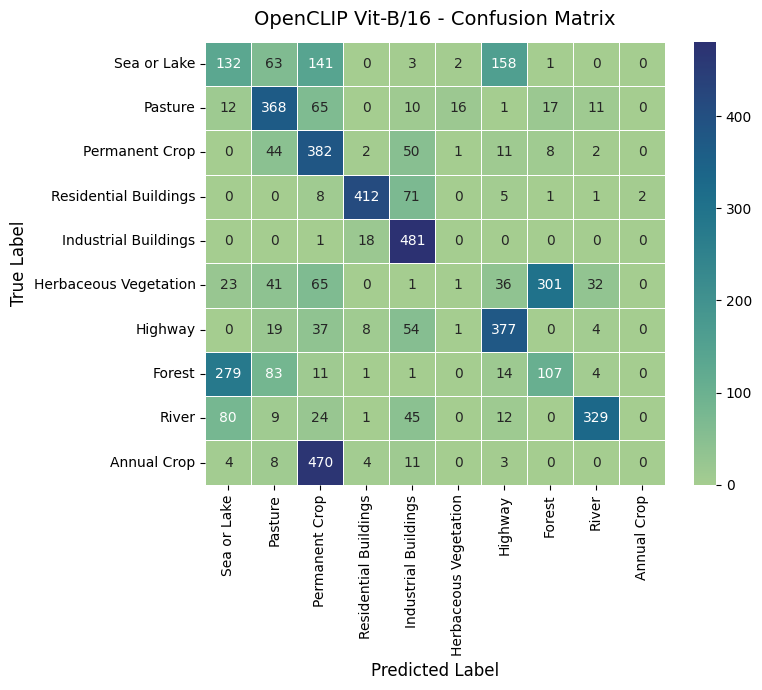

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'OpenCLIP Vit-B/16')

### OpenCLIP ViT-L/14 Classification Predictions

In [ ]:
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device =", device)

OpenCLIP_model_14, _, OpenCLIP_preprocess_14 = open_clip.create_model_and_transforms('ViT-L-14', pretrained = 'laion2b_s32b_b82k')
OpenCLIP_model_14.to(device).eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-L-14')

device = cuda


> **Warning**: takes ~ 4:30 hours to run on Colab CPU! (~ 3 hours on GPU!)

In [ ]:
add_top_predictions_with_batches_jpg(
    test_df,
    OpenCLIP_model_14,
    OpenCLIP_preprocess_14,
    device,
    labels,
    '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_OpenCLIP_ViTL14_RGB.csv',
    tokenizer)

In [ ]:
output_df_openclip_14 = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_OpenCLIP_ViTL14_RGB.csv')
output_df_openclip_14.head()

,image_id,filename,label,Sea_or_Lake_dotprod,Pasture_dotprod,Permanent_Crop_dotprod,Residential_Buildings_dotprod,Industrial_Buildings_dotprod,Herbaceous_Vegetation_dotprod,Highway_dotprod,...,Pasture_sigmoid,Permanent_Crop_sigmoid,Residential_Buildings_sigmoid,Industrial_Buildings_sigmoid,Herbaceous_Vegetation_sigmoid,Highway_sigmoid,Forest_sigmoid,River_sigmoid,Annual_Crop_sigmoid,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.169666,0.163000,0.183244,0.134496,0.131505,0.146107,0.153502,...,0.540660,0.545683,0.533574,0.532829,0.536462,0.538300,0.535333,0.534934,0.543703,Permanent Crop
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.272599,0.210830,0.254161,0.166397,0.159229,0.231035,0.194946,...,0.552513,0.563200,0.541503,0.539723,0.557503,0.548583,0.549457,0.562862,0.549961,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.318251,0.241463,0.293296,0.222507,0.213179,0.269086,0.228730,...,0.560074,0.572803,0.555398,0.553094,0.566869,0.556935,0.558063,0.566055,0.562860,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.150381,0.139785,0.157033,0.097985,0.104617,0.121574,0.126741,...,0.534889,0.539178,0.524477,0.526130,0.530356,0.531643,0.528864,0.528352,0.535976,Permanent Crop
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.178477,0.158516,0.177113,0.127677,0.133979,0.140233,0.151938,...,0.539546,0.544163,0.531876,0.533445,0.535001,0.537912,0.534404,0.536285,0.541558,Sea or Lake


In [ ]:
output_df_openclip_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       5000 non-null   object 
 1   filename                       5000 non-null   object 
 2   label                          5000 non-null   object 
 3   Sea_or_Lake_dotprod            5000 non-null   float64
 4   Pasture_dotprod                5000 non-null   float64
 5   Permanent_Crop_dotprod         5000 non-null   float64
 6   Residential_Buildings_dotprod  5000 non-null   float64
 7   Industrial_Buildings_dotprod   5000 non-null   float64
 8   Herbaceous_Vegetation_dotprod  5000 non-null   float64
 9   Highway_dotprod                5000 non-null   float64
 10  Forest_dotprod                 5000 non-null   float64
 11  River_dotprod                  5000 non-null   float64
 12  Annual_Crop_dotprod            5000 non-null   f

In [ ]:
output_df_openclip_14.pred.value_counts()

,count
pred,
Permanent Crop,1861
Industrial Buildings,534
Residential Buildings,512
Sea or Lake,474
Highway,433
Pasture,396
River,383
Herbaceous Vegetation,250
Forest,151


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_openclip_14["label"]
y_pred = output_df_openclip_14["pred"]

accuracy_openclip_14 = accuracy_score(y_true, y_pred)
accuracy_openclip_14

0.5754

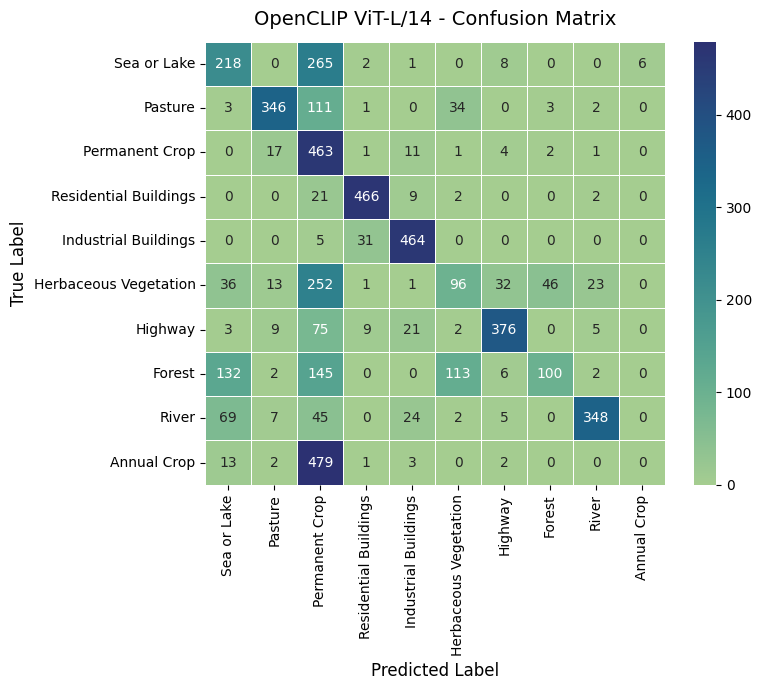

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'OpenCLIP ViT-L/14')

## Loading SigLIP

A state-of-the-art CLIP model using a a simple pairwise sigmoid loss instead of the loss function used in the original CLIP.

- SigLIP vs CLIP: https://medium.com/@jiangmen28/siglip-vs-clip-the-sigmoid-advantage-457f1cb872ab

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

# Loading the SigLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### SigLIP Vit-B/16 Classification Predictions

In [ ]:
SigLIP_model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
SigLIP_processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224") # for both text and image -> no separate tokenizer

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [ ]:
SigLIP_processor

SiglipProcessor:
- image_processor: SiglipImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "SiglipImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "SiglipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

- tokenizer: SiglipTokenizer(name_or_path='google/siglip-base-patch16-224', vocab_size=32000, model_max_length=64, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	1: AddedToken("</s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=True),
	2: AddedToken("<unk>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=True),
}
)

{
  "processor_class": "


 SeaLake_2532.jpg 



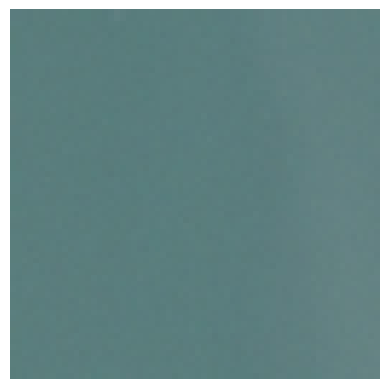


Top predictions:

     Sea or Lake: 0.0000019946
          Forest: 0.0000007026
Herbaceous Vegetation: 0.0000004859
           River: 0.0000002855
         Pasture: 0.0000001241
     Annual Crop: 0.0000000688
         Highway: 0.0000000444
  Permanent Crop: 0.0000000192
Industrial Buildings: 0.0000000033
Residential Buildings: 0.0000000009


In [ ]:
img_id = 'SeaLake_2532.jpg'
filename = test_df[test_df.image_id == img_id].filename.item()

print('\n', img_id, '\n')

im = Image.open(filename)
plt.imshow(im)
plt.axis("off")
plt.show()

# follows the pipeline prompt template to get same results
texts = [f'a satellite photo of {label.lower()}' for label in labels]
# important: we pass `padding=max_length` since the model was trained with this
inputs = SigLIP_processor(text = texts, images = im, padding = "max_length", return_tensors = "pt")

with torch.no_grad():
    outputs = SigLIP_model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image) # these are the probabilities (sigmoid directly, no softmax)

print("\nTop predictions:\n")
results = [r for r in zip(probs[0], labels)] # match probability with text
results = sorted(results, key = lambda x: x[0].item(), reverse = True) # rank in decreasing prob value
for result in results:
    print(f"{result[1]:>16s}: {result[0].item():.10f}")

> **Warning:** the following takes ~ 4:30h to run on CPU! (~ 3:30h on GPU!)

In [ ]:
add_top_predictions_with_chunks_jpg_siglip(test_df,
                                           SigLIP_model,
                                           SigLIP_processor,
                                           device,
                                           labels,
                                           '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_SigLIP_RGB.csv')

100%|██████████| 20/20 [4:24:23<00:00, 793.19s/it]


In [ ]:
output_df_siglip = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_SigLIP_RGB.csv')
output_df_siglip.head()

,image_id,filename,label,Sea_or_Lake_logit,Pasture_logit,Permanent_Crop_logit,Residential_Buildings_logit,Industrial_Buildings_logit,Herbaceous_Vegetation_logit,Highway_logit,...,Pasture_sigmoid_prob,Permanent_Crop_sigmoid_prob,Residential_Buildings_sigmoid_prob,Industrial_Buildings_sigmoid_prob,Herbaceous_Vegetation_sigmoid_prob,Highway_sigmoid_prob,Forest_sigmoid_prob,River_sigmoid_prob,Annual_Crop_sigmoid_prob,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-13.120498,-16.296133,-18.760399,-20.548773,-19.227863,-16.704977,-16.639730,...,8.369111e-08,7.119710e-09,1.190642e-09,4.461132e-09,5.560587e-08,5.935495e-08,2.430493e-07,1.808138e-07,3.633232e-08,Sea or Lake
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-1.040377,-6.279659,-6.748590,-9.384573,-8.235374,-4.466632,-5.811503,...,1.870534e-03,1.171158e-03,8.400309e-05,2.650374e-04,1.135551e-02,2.983996e-03,2.358958e-02,1.543944e-01,8.690009e-04,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,0.717060,-5.050982,-5.201953,-7.169036,-6.542270,-4.856944,-4.337640,...,6.362308e-03,5.475651e-03,7.694722e-04,1.439139e-03,7.714232e-03,1.289878e-02,3.133680e-02,8.850120e-02,9.227217e-03,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-13.583169,-16.557703,-19.028189,-20.803509,-19.399830,-17.032398,-17.032116,...,6.442893e-08,5.447066e-09,9.228922e-10,3.756306e-09,4.007960e-08,4.009092e-08,1.948471e-07,1.156424e-07,2.773640e-08,Sea or Lake
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-13.109202,-15.992777,-18.501457,-20.674931,-19.210535,-16.193047,-16.722500,...,1.133510e-07,9.223998e-09,1.049522e-09,4.539110e-09,9.277890e-08,5.463998e-08,2.068970e-07,1.966802e-07,4.855880e-08,Sea or Lake


In [ ]:
output_df_siglip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   image_id                            5000 non-null   object 
 1   filename                            5000 non-null   object 
 2   label                               5000 non-null   object 
 3   Sea_or_Lake_logit                   5000 non-null   float64
 4   Pasture_logit                       5000 non-null   float64
 5   Permanent_Crop_logit                5000 non-null   float64
 6   Residential_Buildings_logit         5000 non-null   float64
 7   Industrial_Buildings_logit          5000 non-null   float64
 8   Herbaceous_Vegetation_logit         5000 non-null   float64
 9   Highway_logit                       5000 non-null   float64
 10  Forest_logit                        5000 non-null   float64
 11  River_logit                         5000 no

In [ ]:
output_df_siglip.pred.value_counts()

,count
pred,
Sea or Lake,977
Highway,898
Forest,772
Industrial Buildings,624
River,610
Annual Crop,469
Residential Buildings,357
Pasture,203
Herbaceous Vegetation,52


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_siglip["label"]
y_pred = output_df_siglip["pred"]

accuracy_siglip = accuracy_score(y_true, y_pred)
accuracy_siglip

0.453

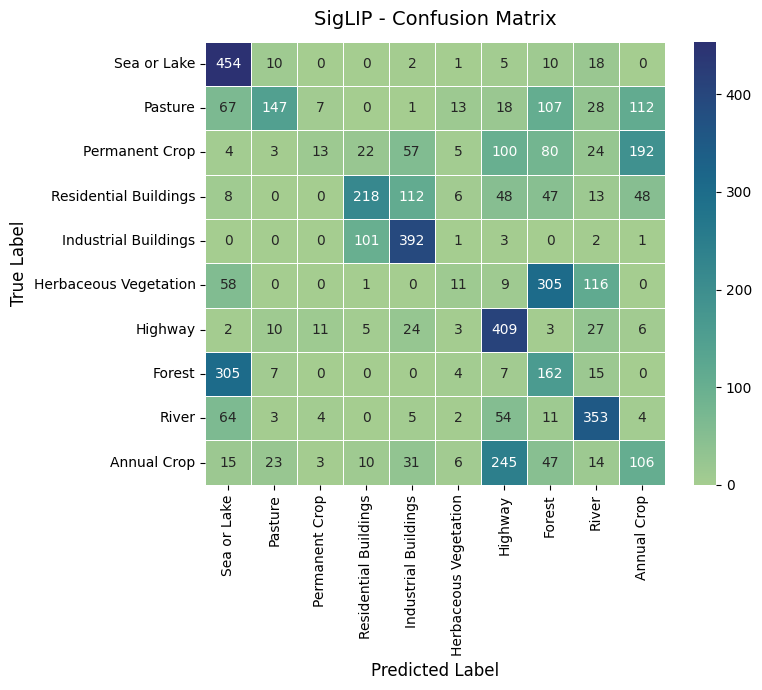

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'SigLIP')

### SigLIP Vit-B/32 Classification Predictions

Model card: https://huggingface.co/timm/ViT-B-32-SigLIP2-256

In [ ]:
%%capture
! pip install open-clip-torch

In [ ]:
from open_clip import create_model_from_pretrained, get_tokenizer
# works on open-clip-torch >= 2.31.0, timm >= 1.0.15

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

SigLIP2_model, SigLIP2_preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-32-SigLIP2-256')
SigLIP2_tokenizer = get_tokenizer('hf-hub:timm/ViT-B-32-SigLIP2-256')

SigLIP2_model = SigLIP2_model.to(device)

cuda



 SeaLake_2532.jpg 



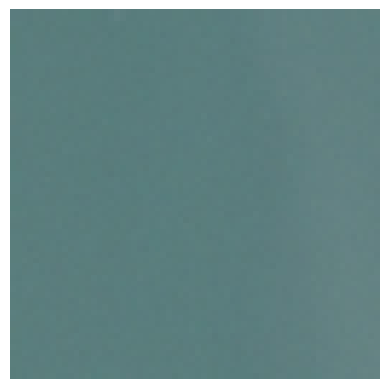


Label probabilities:

     Sea or Lake: 0.0178581948
  Permanent Crop: 0.0108341126
           River: 0.0099858677
          Forest: 0.0078699217
         Pasture: 0.0071577808
     Annual Crop: 0.0053541498
         Highway: 0.0047470225
Herbaceous Vegetation: 0.0041589163
Industrial Buildings: 0.0008917847
Residential Buildings: 0.0006793522


In [ ]:
img_id = 'SeaLake_2532.jpg'
filename = test_df[test_df.image_id == img_id].filename.item()

print('\n', img_id, '\n')

im = Image.open(filename)
plt.imshow(im)
plt.axis("off")
plt.show()

image = SigLIP2_preprocess(im).unsqueeze(0).to(device)

# follows the pipeline prompt template to get same results
texts = [f'a satellite photo of {label.lower()}' for label in labels]

text = SigLIP2_tokenizer(texts, context_length = SigLIP2_model.context_length).to(device)

with torch.no_grad(): #, torch.amp.autocast('cuda'):
    image_features = SigLIP2_model.encode_image(image, normalize=True)
    text_features = SigLIP2_model.encode_text(text, normalize=True)
    logits = (image_features @ text_features.T * SigLIP2_model.logit_scale.exp() + SigLIP2_model.logit_bias)
    text_probs = torch.sigmoid(logits)

zipped_list = list(zip(labels, [100 * p.item() for p in text_probs[0]]))
print("\nLabel probabilities:\n")
for label, prob in sorted(zipped_list, key = lambda x: x[1], reverse = True):
    print(f"{label:>16s}: {prob:.10f}")

> **Warning:** the following takes ~ 1h to run on GPU

In [ ]:
add_top_predictions_with_batches_jpg_siglip2(test_df,
                                             SigLIP2_model,
                                             SigLIP2_preprocess,
                                             device,
                                             labels,
                                              '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_SigLIP2_RGB.csv',
                                             SigLIP2_tokenizer)

100%|██████████| 20/20 [1:06:38<00:00, 199.95s/it]


In [ ]:
output_df_siglip2 = pd.read_csv( '/content/drive/MyDrive/Thesis CLIP4EO/output/EuroSAT_5000_predictions_SigLIP2_RGB.csv')
output_df_siglip2.head()

,image_id,filename,label,Sea_or_Lake_logit,Pasture_logit,Permanent_Crop_logit,Residential_Buildings_logit,Industrial_Buildings_logit,Herbaceous_Vegetation_logit,Highway_logit,...,Pasture_sigmoid_prob,Permanent_Crop_sigmoid_prob,Residential_Buildings_sigmoid_prob,Industrial_Buildings_sigmoid_prob,Herbaceous_Vegetation_sigmoid_prob,Highway_sigmoid_prob,Forest_sigmoid_prob,River_sigmoid_prob,Annual_Crop_sigmoid_prob,pred
0,SeaLake_1041.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-9.001091,-10.810211,-10.053718,-11.757551,-11.749878,-12.219049,-10.061652,...,0.000020,0.000043,0.000008,0.000008,0.000005,0.000043,0.000011,0.000023,0.000013,Sea or Lake
1,SeaLake_2995.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-0.456242,-3.246678,-3.503060,-5.673739,-5.385691,-3.333433,-3.312376,...,0.037446,0.029225,0.003423,0.004561,0.034442,0.035149,0.044455,0.189888,0.009264,Sea or Lake
2,SeaLake_2715.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-3.437012,-5.118735,-4.804893,-5.653666,-5.124162,-5.535171,-4.927350,...,0.005948,0.008123,0.003492,0.005916,0.003930,0.007194,0.005486,0.010235,0.003030,Sea or Lake
3,SeaLake_516.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-9.199715,-10.935843,-10.170516,-12.173624,-12.082691,-12.205238,-10.431056,...,0.000018,0.000038,0.000005,0.000006,0.000005,0.000030,0.000010,0.000017,0.000012,Sea or Lake
4,SeaLake_1346.jpg,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Sea or Lake,-9.079134,-10.754947,-9.998320,-11.964802,-11.771152,-11.981099,-10.172945,...,0.000021,0.000045,0.000006,0.000008,0.000006,0.000038,0.000012,0.000023,0.000015,Sea or Lake


In [ ]:
output_df_siglip2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   image_id                            5000 non-null   object 
 1   filename                            5000 non-null   object 
 2   label                               5000 non-null   object 
 3   Sea_or_Lake_logit                   5000 non-null   float64
 4   Pasture_logit                       5000 non-null   float64
 5   Permanent_Crop_logit                5000 non-null   float64
 6   Residential_Buildings_logit         5000 non-null   float64
 7   Industrial_Buildings_logit          5000 non-null   float64
 8   Herbaceous_Vegetation_logit         5000 non-null   float64
 9   Highway_logit                       5000 non-null   float64
 10  Forest_logit                        5000 non-null   float64
 11  River_logit                         5000 no

In [ ]:
output_df_siglip2.pred.value_counts()

,count
pred,
Pasture,1100
Sea or Lake,894
Residential Buildings,832
Highway,616
River,583
Industrial Buildings,371
Forest,326
Permanent Crop,185
Annual Crop,72


In [ ]:
from sklearn.metrics import accuracy_score

y_true = output_df_siglip2["label"]
y_pred = output_df_siglip2["pred"]

accuracy_siglip = accuracy_score(y_true, y_pred)
accuracy_siglip

0.5018

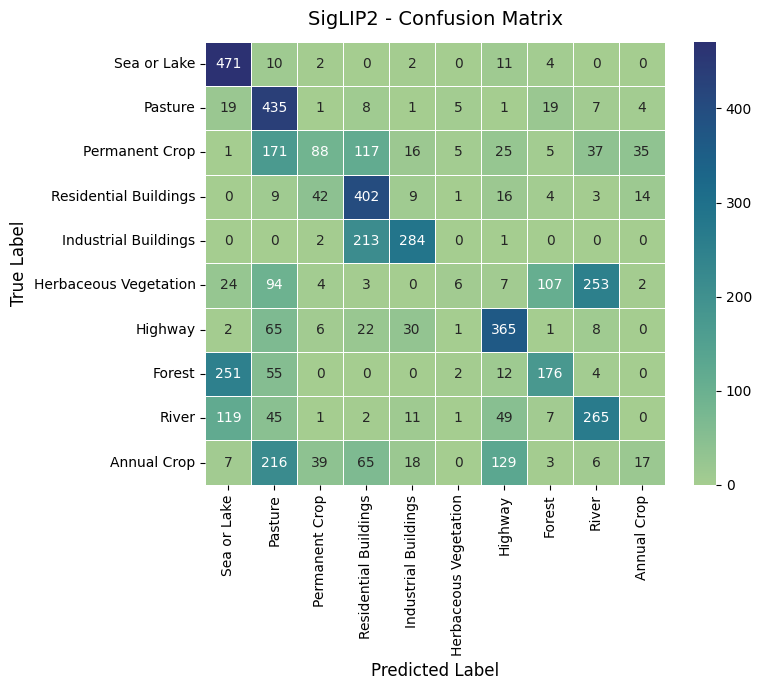

In [ ]:
plot_confusion_matrix(y_true, y_pred, labels, 'SigLIP2')

## Evaluation Summary

EuroSAT RGB Zero-Shot baselines

| Model       | Backbone | Accuracy |
| --------    | -------  | -------  |
| CLIP        | ViT-B/32 |  38.76%  |
| CLIP        | ViT-B/16 |  43.98%  |
| OpenCLIP    | ViT-B/32 |  44.76%  |
| OpenCLIP    | ViT-B/16 |  51.78%  |
| OpenCLIP    | ViT-L/14 |  57.54%  |
| RemoteCLIP  | ViT-B/32 |  37.34%  |
| GeoRSCLIP   | ViT-B/32 |  53.54%  |
| RS-M-CLIP   | ViT-B/32 |  25.86%  |
| SkyCLIP     | ViT-B/32 |  52.26%  |
| SigLIP      | ViT-B/16 |  45.30%  |
| SigLIP2     | ViT-B/32 |  50.18%  |


In [ ]:
# [INSERT ACCURACY PLOT FOR EASIER VISUALIZATION]

# models_and_accuracies = {"CLIP ViT-B/32" : accuracy_clip,
#                          "CLIP ViT-B/16" : accuracy_clip_16,
#                          "OpenCLIP ViT-B/32" : accuracy_openclip,
#                          "OpenCLIP ViT-B/16" : accuracy_openclip_16,
#                          "OpenCLIP ViT-L/14" : accuracy_openclip_14,
#                          "RemoteCLIP" : accuracy_remoteclip,
#                          "GeoRSCLIP" : accuracy_georsclip,
#                          "RS-M-CLIP" : accuracy_rsmclip,
#                          "SkyCLIP" : accuracy_skyclip,
#                          "SigLIP" : accuracy_siglip}

# model_names = list(models_and_accuracies.keys())
# accuracies = list(models_and_accuracies.values())
# print(model_names)
# print(accuracies)